In [13]:
library(sf)
library(tmap)
library(tmaptools)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gstat)
library(sp)
library(spdep)

# Create map directory if it doesn't exist
if (!dir.exists("./map")) {
  dir.create("./map")
}

# Read the census shapefile
census <- st_read(dsn="./data/nyc2020_census/nyct2020.shp", layer="nyct2020")

# Load the population csv data
population <- read.csv("./data/nyc_censusdata_2020.csv")
population$BCT2020 <- as.character(population$BCT2020)

# Join population data to census data
census_joined <- census %>%
  left_join(population, by= c("BoroCT2020"="BCT2020"))

# Filter out Staten Island
census_joined <- census_joined %>%
  filter(BoroName != "Staten Island")

# Load Citibike data
citibike_1 <- read.csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_1.csv")
citibike_2 <- read.csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_2.csv")
citibike_3 <- read.csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_3.csv")

citibike_july <- bind_rows(citibike_1, citibike_2, citibike_3)

# Convert starttime and stoptime into DateTime format
citibike_july$starttime <- ymd_hms(citibike_july$starttime)
citibike_july$stoptime <- ymd_hms(citibike_july$stoptime)

# Cleaning up for weekday/weekend and hour information
citibike_july <- citibike_july %>%
  mutate(
    is_weekend = ifelse(wday(starttime) %in% c(1,7), TRUE, FALSE),
    start_hour = hour(starttime)
  )

# Create the station dataset with attributes on station id/lat/long, ride counts
start_station_july <- citibike_july %>%
  group_by(start.station.id, start.station.latitude, start.station.longitude) %>%
  summarise(
    ride_start_count = n()
  ) %>%
  rename(
    station_id = start.station.id,
    station_latitude = start.station.latitude,
    station_longitude = start.station.longitude
  )

# Calculate end station counts  
end_station_july <- citibike_july %>%
  group_by(end.station.id, end.station.latitude, end.station.longitude) %>%
  summarise(
    ride_end_count = n()
  ) %>%
  rename(
    station_id = end.station.id,
    station_latitude = end.station.latitude,
    station_longitude = end.station.longitude
  )

# Combine start and end to return ride activity by station
station_july <- full_join(start_station_july, end_station_july,
                          by= c("station_id", "station_latitude", "station_longitude")) %>%
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  )

# Convert cleaned July dataset into sf object
station_july_sf <- station_july %>%
  st_as_sf(coords = c("station_longitude", "station_latitude"), crs=4326, remove=FALSE)

# Convert Census polygon crs4269 to crs4329
census_joined <- st_transform(census_joined, crs=st_crs(station_july_sf))

# Creating an aggregated station dataset at census tract level
station_july_nyc <- station_july_sf %>%
  st_join(census_joined, join= st_within, left=FALSE)

ct_station_july <- station_july_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    total_ride_activity = sum(ride_activity, na.rm=TRUE)
  )

# Converting to df to allow for inner join and drop column for polygons without Citibike docks
ct_station_july_df <- as.data.frame(ct_station_july)
agg_citibike_july <- census_joined %>%
  inner_join(ct_station_july_df, by= "BoroCT2020")

Reading layer `nyct2020' from data source 
  `/Users/jiazhuangfeng/Documents/project/spatial_analysis/assignment/data/nyc2020_census/nyct2020.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2325 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 913175.1 ymin: 120128.4 xmax: 1067383 ymax: 272844.3
Projected CRS: NAD83 / New York Long Island (ftUS)


`summarise()` has grouped output by 'start.station.id', 'start.station.latitude'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'end.station.id', 'end.station.latitude'. You can override using the `.groups` argument.


In [22]:
# 过滤掉没有数据的多边形
valid_indices <- !is.na(agg_citibike_july$total_ride_activity)
census_sp <- census_sp[valid_indices, ]
agg_citibike_july <- agg_citibike_july[valid_indices, ]

# 创建邻接矩阵
nb <- poly2nb(census_sp, snap = 0.1)

# 创建空间权重矩阵
listw <- nb2listw(nb, style = "W", zero.policy = TRUE)

# 计算 Moran's I
moran_test <- moran.test(agg_citibike_july$total_ride_activity, listw, zero.policy = TRUE)

# 查看结果
print(moran_test)


Warning message in poly2nb(census_sp, snap = 0.1):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(census_sp, snap = 0.1):
“neighbour object has 34 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”



	Moran I test under randomisation

data:  agg_citibike_july$total_ride_activity  
weights: listw  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 6.3979, p-value = 7.876e-11
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.233987289      -0.002341920       0.001364451 



Warning message in poly2nb(census_sp, snap = 0.1):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(census_sp, snap = 0.1):
“neighbour object has 34 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”


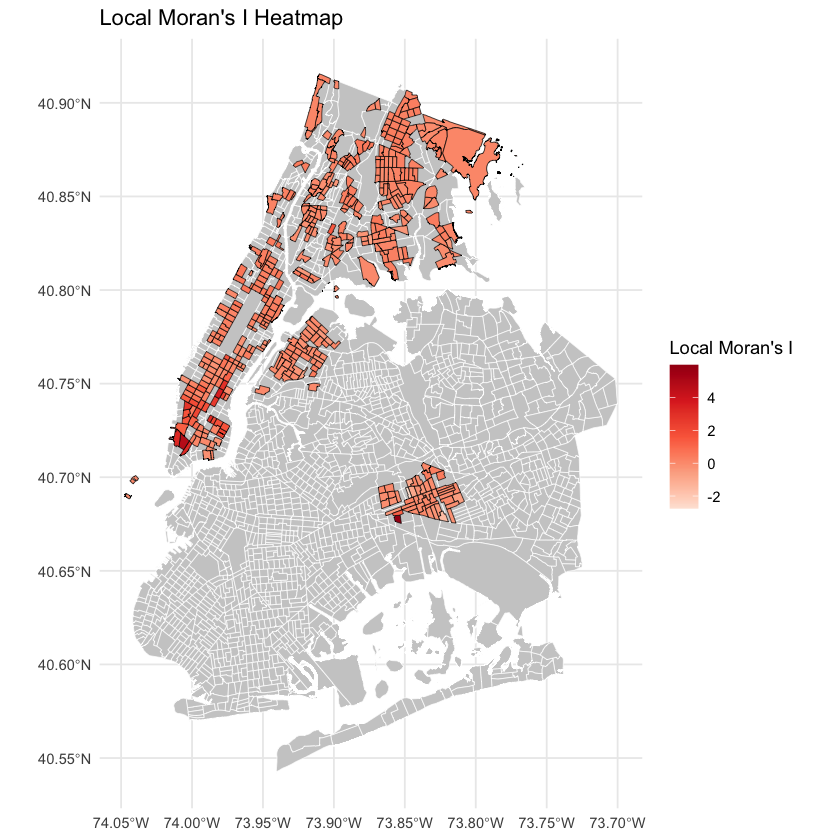

In [28]:
library(spdep)
library(ggplot2)
library(sf)
library(RColorBrewer)

# 过滤掉没有数据的多边形
valid_indices <- !is.na(agg_citibike_july$total_ride_activity) & agg_citibike_july$total_ride_activity > 0
census_sp <- census_sp[valid_indices, ]
agg_citibike_july <- agg_citibike_july[valid_indices, ]

# 创建邻接矩阵
nb <- poly2nb(census_sp, snap = 0.1)

# 创建空间权重矩阵
listw <- nb2listw(nb, style = "W", zero.policy = TRUE)

# 计算 Local Moran's I
local_moran <- localmoran(agg_citibike_july$total_ride_activity, listw, zero.policy = TRUE)

# 将 Local Moran's I 结果添加到数据框
census_sp$local_moran_I <- local_moran[, "Ii"]

# 将数据转换为 sf 对象
census_sf <- st_as_sf(census_sp)

# 绘制热力图
ggplot() +
  geom_sf(data = census_joined, fill = "grey80", color = "white", size = 0.2) + # 背景地图
  geom_sf(data = census_sf, aes(fill = local_moran_I), color = "black", size = 0.1) +
  scale_fill_gradientn(colors = brewer.pal(5, "Reds"), na.value = "grey90") +
  theme_minimal() +
  labs(title = "Local Moran's I Heatmap",
       fill = "Local Moran's I")

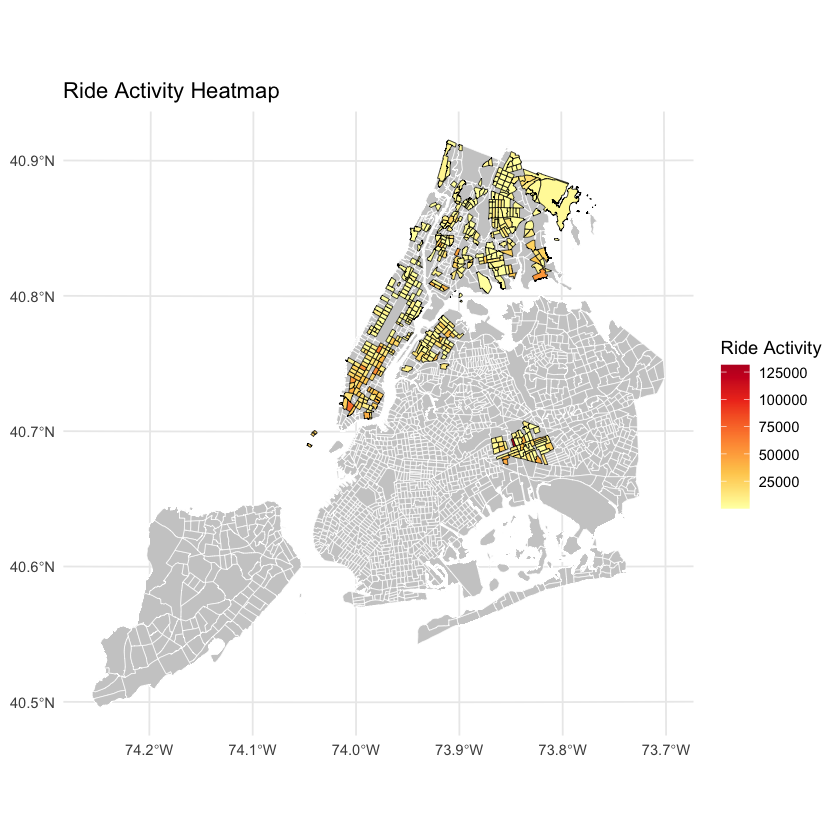

In [29]:
# 确保 agg_citibike_july 中的数据与 census_sp 匹配
census_sp$ride_activity <- agg_citibike_july$total_ride_activity

# 将数据转换为 sf 对象
census_sf <- st_as_sf(census_sp)

# 绘制骑行活动热力图
ggplot() +
  geom_sf(data = census, fill = "grey80", color = "white", size = 0.2) + # 背景地图
  geom_sf(data = census_sf, aes(fill = ride_activity), color = "black", size = 0.1) +
  scale_fill_gradientn(colors = brewer.pal(5, "YlOrRd"), na.value = "grey90") +
  theme_minimal() +
  labs(title = "Ride Activity Heatmap",
       fill = "Ride Activity")


In [9]:
# 计算有数据的行数（即没有缺失值的行）
complete_cases <- sum(complete.cases(agg_citibike_july$ride_activity))
print(paste("有数据的行数:", complete_cases))


[1] "有数据的行数: 0"


In [14]:
# 检查每一列的缺失值数量
missing_values_per_column <- sapply(agg_citibike_july, function(x) sum(is.na(x)))

# 打印每一列缺失值的数量
print(missing_values_per_column)


            CTLabel            BoroCode            BoroName              CT2020 
                  0                   0                   0                   0 
         BoroCT2020          CDEligibil             NTAName             NTA2020 
                  0                 441                   0                   0 
           CDTA2020            CDTANAME               GEOID                PUMA 
                  0                   0                   0                   0 
         Shape_Leng          Shape_Area                Year             GeoType 
                  0                   0                   0                   0 
            Borough               GeoID                Pop1              Male.P 
                  0                   0                   0                   3 
               FemP               PopU5              Pop5t9            Pop10t14 
                  3                   0                   0                   0 
           Pop15t19         